In [111]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.font_manager import fontManager
import matplotlib
import pandas as pd
import properscoring as ps
from scipy.stats import t
import seaborn as sns

In [ ]:
pred_con = np.load("results/pred_20260104_235112_best_post_test.npy")
truths_con = np.load("results/truths_20260104_235112_best_post_test.npy")
samples_con = np.load("results/samples_20260104_235112_best_post_test.npy")

pred=np.load("results/pred_20251220_223951_second_best_val_post_test.npy")
truths=np.load("results/truths.npy")
samples=np.load("results/samples_20251220_223951_second_best_val_post_test.npy")


In [221]:
pred_con.shape

(433, 12, 275)

In [222]:
pred.shape

(412, 12, 275)

In [223]:
truths_con.shape

(433, 12, 275)

In [224]:
pol8 = np.load('./urbanev/did_policy_8_test.npz', allow_pickle=True)
pol12 = np.load('./urbanev/did_policy_12_test.npz', allow_pickle=True)

In [225]:
pol8['D8'].shape

(19, 275)

In [226]:
pol8['D8'][0].shape

(275,)

In [227]:
from collections import defaultdict

def _to_window_format(x, T=360, L=12, N=275):
    """
    将真值转换为滑窗格式 (360,12,275)：
    - 如果已是 (360,12,275)，直接返回
    - 如果是 (360,275)，认为是每小时一个值，复制成窗口（每个窗口仅用于对齐；若你想让gt窗口有真实12步，可自行传入真实gt_win）
    - 如果是 (15,24,275)，reshape 成 (360,275) 再复制成窗口
    """
    x = np.asarray(x)
    if x.shape == (T, L, N):
        return x

    if x.shape == (T, N):
        # 注意：这会让 gt_win[i,k] == gt_hourly[i]，即窗口内12步相同，仅用于“画图对齐”。
        # 若你有真实的未来12步真值滑窗，请直接传 (360,12,275) 版本。
        gt_win = np.repeat(x[:, None, :], L, axis=1)  # (360,12,275)
        return gt_win

    if x.shape == (15, 24, N):
        x2 = x.reshape(T, N)
        gt_win = np.repeat(x2[:, None, :], L, axis=1)
        return gt_win

    raise ValueError(f"Unsupported gt shape: {x.shape}. 期望 (360,12,275) 或 (360,275) 或 (15,24,275).")


def _bucketize_all_values(win, hours, T=360, L=12):
    """
    将滑窗 win (360,12,275) 投影到真实时间(day,hour)桶：
    bucket[(day,hour)] -> list of (275,) arrays
    """
    win = np.asarray(win)
    bucket = defaultdict(list)

    for i in range(T):      # 窗口起点（小时）
        for k in range(L):  # 窗内偏移（小时）
            t = i + k
            if t >= T:
                continue
            day = t // 24
            hour = t % 24
            if hour in hours:
                bucket[(day, hour)].append(win[i, k])  # (275,)
    return bucket


def plot_pred_gt_4lines_all_values(
    pred_win,
    gt,
    D,
    PSM_IN,
    hours=(4, 5, 6, 7, 8,9,10),
):
    """
    pred_win: (360,12,275) 预测滑窗
    gt:      真值，可为 (360,12,275) 或 (360,275) 或 (15,24,275)
    D, PSM_IN: (15,275) 0/1
    hours: 仅统计每天这些小时
    """

    pred_win = np.asarray(pred_win)
    D = np.asarray(D)
    PSM_IN = np.asarray(PSM_IN)

    T, L, N = pred_win.shape
    assert (T, L, N) == (360, 12, 275), f"pred_win shape应为(360,12,275)，实际 {pred_win.shape}"
    assert D.shape == (15, 275), f"D shape应为(15,275)，实际 {D.shape}"
    assert PSM_IN.shape == (15, 275), f"PSM_IN shape应为(15,275)，实际 {PSM_IN.shape}"

    hours = list(hours)

    # 1) 真值转成滑窗格式
    gt_win = _to_window_format(gt, T=360, L=12, N=275)

    # 2) 分别把 pred / gt 的“所有有效滑窗值”投影到 (day,hour) 桶
    pred_bucket = _bucketize_all_values(pred_win, hours, T=360, L=12)
    gt_bucket   = _bucketize_all_values(gt_win,   hours, T=360, L=12)

    # 3) 计算每一天、每小时、两组区域均值：D&PSM vs not D
    pred_g1_by_day = np.full((15, len(hours)), np.nan)
    pred_g2_by_day = np.full((15, len(hours)), np.nan)
    gt_g1_by_day   = np.full((15, len(hours)), np.nan)
    gt_g2_by_day   = np.full((15, len(hours)), np.nan)

    for d in range(15):
        mask_g1 = (D[d] == 1) & (PSM_IN[d] == 1)
        mask_g2 = (D[d] == 0) & (PSM_IN[d] == 1)

        for j, h in enumerate(hours):
            key = (d, h)

            # ---------- pred ----------
            if key in pred_bucket:
                x = np.stack(pred_bucket[key], axis=0)  # (num_obs, 275)
                if mask_g1.any():
                    pred_g1_by_day[d, j] = x[:, mask_g1].mean()
                if mask_g2.any():
                    pred_g2_by_day[d, j] = x[:, mask_g2].mean()

            # ---------- gt ----------
            if key in gt_bucket:
                y = np.stack(gt_bucket[key], axis=0)    # (num_obs, 275)
                if mask_g1.any():
                    gt_g1_by_day[d, j] = y[:, mask_g1].mean()
                if mask_g2.any():
                    gt_g2_by_day[d, j] = y[:, mask_g2].mean()

    # 4) 对 15 天取平均（忽略 NaN）
    pred_g1_mean = np.nanmean(pred_g1_by_day, axis=0)
    pred_g2_mean = np.nanmean(pred_g2_by_day, axis=0)
    gt_g1_mean   = np.nanmean(gt_g1_by_day, axis=0)
    gt_g2_mean   = np.nanmean(gt_g2_by_day, axis=0)

    # 5) 画四条线
    plt.figure(figsize=(9, 5))
    plt.plot(hours, pred_g1_mean, marker="o", label="Pred: D=1 & PSM_IN=1")
    plt.plot(hours, pred_g2_mean, marker="o", label="Pred: D=0 & PSM_IN=1")
    plt.plot(hours, gt_g1_mean,   marker="s", linestyle="--", label="GT:   D=1 & PSM_IN=1")
    plt.plot(hours, gt_g2_mean,   marker="s", linestyle="--", label="GT:   D=0 & PSM_IN=1")

    plt.xticks(hours)
    plt.xlabel("Hour of day")
    plt.ylabel("Occupancy")
    plt.title(f"Occupancy ({hours[0]:02d}:00–{hours[-1]:02d}:00)")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "hours": np.array(hours),
        "pred_g1_by_day": pred_g1_by_day,
        "pred_g2_by_day": pred_g2_by_day,
        "gt_g1_by_day": gt_g1_by_day,
        "gt_g2_by_day": gt_g2_by_day,
        "pred_g1_mean": pred_g1_mean,
        "pred_g2_mean": pred_g2_mean,
        "gt_g1_mean": gt_g1_mean,
        "gt_g2_mean": gt_g2_mean,
    }

In [228]:
con_start=36
con_end=396
start=15
end=375

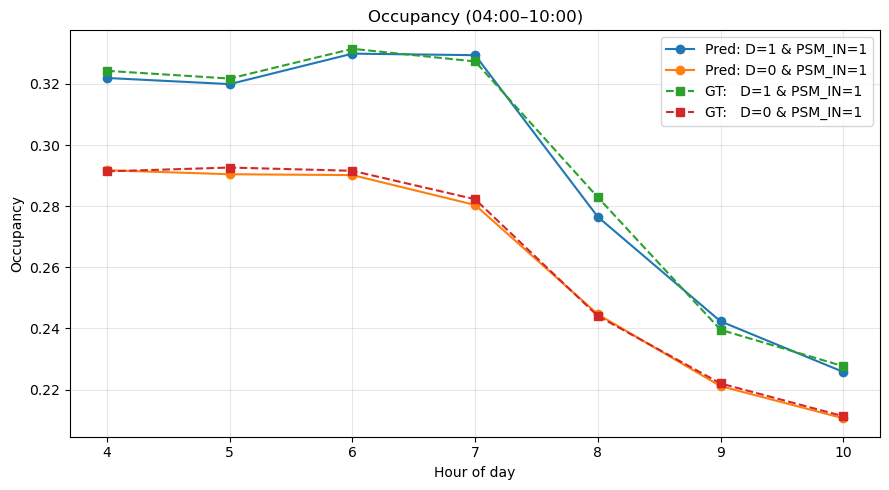

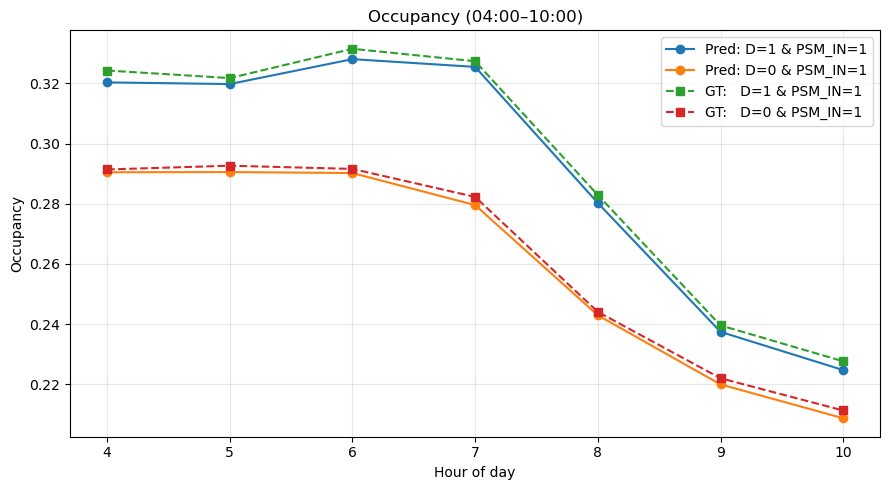

In [229]:
result = plot_pred_gt_4lines_all_values(pred_win=pred_con[con_start:con_end], gt=truths_con[con_start:con_end], D=pol8['D8'][2:17], PSM_IN=pol8['PSM_IN8'][2:17])
result = plot_pred_gt_4lines_all_values(pred_win=pred[start:end], gt=truths_con[con_start:con_end], D=pol8['D8'][2:17], PSM_IN=pol8['PSM_IN8'][2:17])

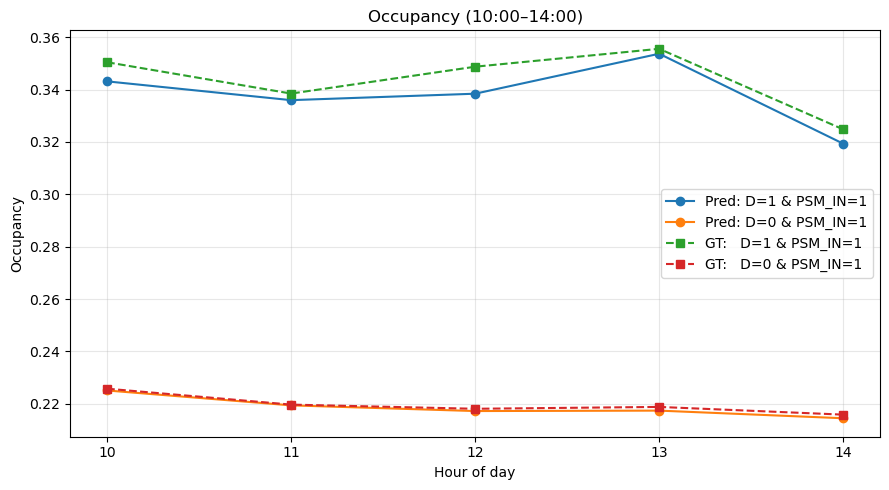

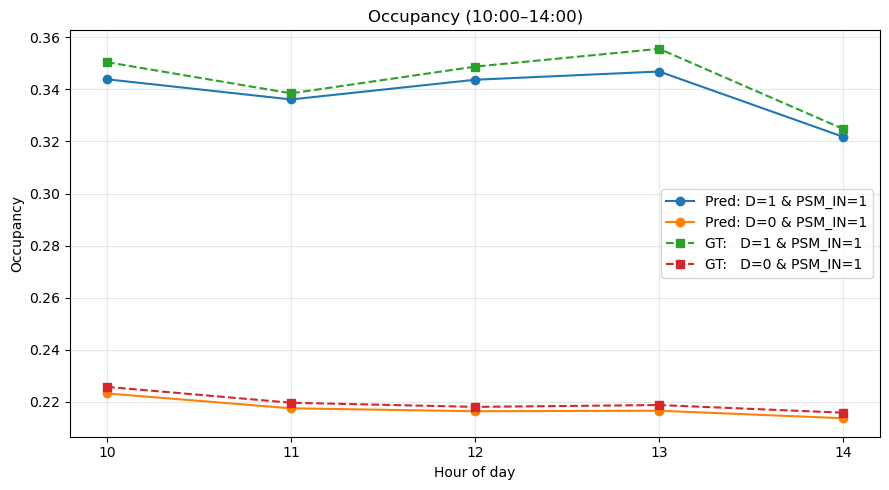

In [230]:
result = plot_pred_gt_4lines_all_values(pred_win=pred_con[con_start:con_end], gt=truths_con[con_start:con_end], D=pol12['D12'][2:17], PSM_IN=pol12['PSM_IN12'][2:17],hours=(10,11,12,13,14))
result = plot_pred_gt_4lines_all_values(pred_win=pred[start:end], gt=truths_con[con_start:con_end], D=pol12['D12'][2:17], PSM_IN=pol12['PSM_IN12'][2:17],hours=(10,11,12,13,14))

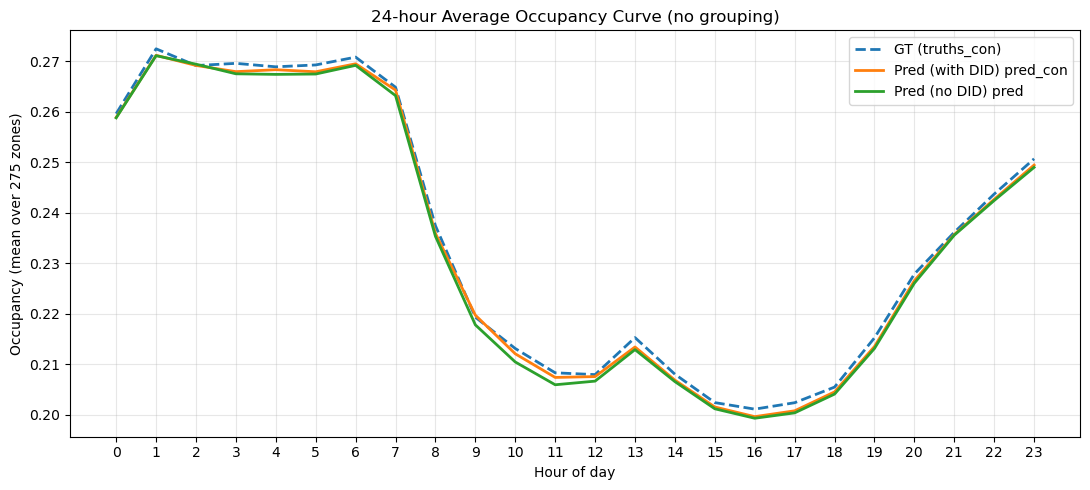

Counts per hour (with DID): [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180]
Counts per hour (GT):       [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180]
Counts per hour (no DID):   [180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 180]


In [231]:
def hourly_mean_curve_from_sliding(values_3d, n_hours=24, agg="mean"):
    """
    values_3d: (N_samples, L, N_nodes)
      - N_samples=360
      - L=12 (未来步长=60min)
      - N_nodes=275
    样本按小时循环排列：第 i 个样本起始小时 = i % 24
    折叠回 24 小时钟面后，计算每小时的平均曲线（不分组）。
    """
    N_samples, L, N_nodes = values_3d.shape

    # 1) 先对 275 个区聚合成标量：每个样本每个步长一个值 -> (N_samples, L)
    if agg == "mean":
        values_2d = values_3d.mean(axis=2)
        y_label = "Occupancy (mean over 275 zones)"
    elif agg == "sum":
        values_2d = values_3d.sum(axis=2)
        y_label = "Occupancy (sum over 275 zones)"
    else:
        raise ValueError("agg must be 'mean' or 'sum'")

    # 2) 起始小时：按小时循环排列
    start_hours = np.arange(N_samples) % n_hours  # (N_samples,)

    # 3) 折叠聚合到 24 小时
    buckets = [[] for _ in range(n_hours)]
    for i in range(N_samples):
        s = int(start_hours[i])
        for t in range(L):
            h = (s + t) % n_hours
            buckets[h].append(values_2d[i, t])

    hourly_mean = np.array([np.mean(b) if len(b) > 0 else np.nan for b in buckets])
    hourly_cnt  = np.array([len(b) for b in buckets], dtype=int)

    return hourly_mean, hourly_cnt, y_label

# --------- 计算三条曲线 ---------
curve_pred_con, cnt_pred_con, y_label = hourly_mean_curve_from_sliding(pred_con[con_start:con_end], agg="mean")
curve_truths_con, cnt_truths_con, _   = hourly_mean_curve_from_sliding(truths_con[con_start:con_end], agg="mean")
curve_pred, cnt_pred, _               = hourly_mean_curve_from_sliding(pred[start:end], agg="mean")

# --------- 画图 ---------
hours = np.arange(24)

plt.figure(figsize=(11, 5))
plt.plot(hours, curve_truths_con, linestyle="--", linewidth=2, label="GT (truths_con)")
plt.plot(hours, curve_pred_con, linewidth=2, label="Pred (with DID) pred_con")
plt.plot(hours, curve_pred, linewidth=2, label="Pred (no DID) pred")

plt.xticks(hours)
plt.xlabel("Hour of day")
plt.ylabel(y_label)
plt.title("24-hour Average Occupancy Curve (no grouping)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("Counts per hour (with DID):", cnt_pred_con.tolist())
print("Counts per hour (GT):      ", cnt_truths_con.tolist())
print("Counts per hour (no DID):  ", cnt_pred.tolist())


In [232]:
def build_day_hour_mats(T=360, L=12):
    i = np.arange(T)[:, None]          # (T,1)
    k = np.arange(L)[None, :]          # (1,L)
    t = i + k                          # (T,L)
    valid = t < T                      # (T,L)
    day = (t // 24).astype(int)        # (T,L) in [0,14]
    hour = (t % 24).astype(int)        # (T,L) in [0,23]
    return day, hour, valid

def hour_in_ranges(hour_mat, ranges):
    """
    hour_mat: (T,L) int in [0,23]
    ranges: list of (h0,h1), 左闭右开；支持跨午夜 (23,2)
    """
    mask = np.zeros_like(hour_mat, dtype=bool)
    for h0, h1 in ranges:
        if h0 < h1:
            mask |= (hour_mat >= h0) & (hour_mat < h1)
        else:
            mask |= (hour_mat >= h0) | (hour_mat < h1)
    return mask


def subset_metrics_from_mask(pred_win, gt_win, mask_3d, eps_mape=1e-3):
    """
    pred_win, gt_win: (360,12,275)
    mask_3d: (360,12,275) bool
    """
    y_hat = pred_win[mask_3d]
    y     = gt_win[mask_3d]
    n = y.size
    if n == 0:
        return {"n": 0, "msg": "Empty subset."}

    err = y_hat - y
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))

    denom = float(np.sum(np.abs(y - np.mean(y))) + 1e-12)
    rae = float(np.sum(np.abs(err)) / denom)

    m_mask = np.abs(y) > eps_mape
    if np.any(m_mask):
        mape = float(np.mean(np.abs(err[m_mask] / y[m_mask])) * 100.0)
    else:
        mape = np.nan

    return {"n": int(n), "mae": mae, "rmse": rmse, "rae": rae, "mape(%)": mape}

def eval_policy_subset(pred_win, gt_win, D_day_zone, PSM_IN_day_zone,
                       policy_ranges=[(7,9), (12,14)],
                       mode="all_psm",
                       eps_mape=1e-3):
    """
    pred_win, gt_win: (360,12,275)
    D_day_zone, PSM_IN_day_zone: (15,275)
    与你 notebook 的 t=i+k, 且只保留 t<360 完全一致。
    """
    T, L, Z = pred_win.shape
    assert (T, L, Z) == gt_win.shape
    assert D_day_zone.shape == (15, Z)
    assert PSM_IN_day_zone.shape == (15, Z)

    # t=i+k 对齐
    i = np.arange(T)[:, None]
    k = np.arange(L)[None, :]
    t = i + k                              # (T,L)
    valid = (t < 360)                      # (T,L)
    day_mat  = (t // 24).astype(int)       # (T,L) 可能出现 15
    hour_mat = (t % 24).astype(int)

    # 关键：先把 day 索引变安全，再用 valid 抹掉越界点
    day_safe = np.clip(day_mat, 0, 14)     # 避免索引 15 越界

    # 提升 day×zone -> (T,L,Z)
    PSM_3d = PSM_IN_day_zone[day_safe]     # (T,L,Z)
    D_3d   = D_day_zone[day_safe]          # (T,L,Z)

    # 政策时段 mask
    mask_time = valid & hour_in_ranges(hour_mat, policy_ranges)  # (T,L)

    if mode == "all":
        mask_space = np.ones((T, L, Z), dtype=bool) 
    elif mode == "all_psm":
        mask_space = (PSM_3d == 1)
    elif mode == "treated_psm":
        mask_space = (PSM_3d == 1) & (D_3d == 1)
    elif mode == "control_psm":
        mask_space = (PSM_3d == 1) & (D_3d == 0)
    else:
        raise ValueError("mode must be one of: all_psm / treated_psm / control_psm")

    mask_3d = mask_time[:, :, None] & mask_space

    return subset_metrics_from_mask(pred_win, gt_win, mask_3d, eps_mape=eps_mape)



In [233]:
policy_ranges = [(5,9)]  # 或你要的更精细窗口也行，比如 [(5,8)]
D = pol8["D8"][2:17]
PSM_IN = pol8["PSM_IN8"][2:17]

print("=== 8AM policy subset (PSM_IN=1) ===")
print("With DID:", eval_policy_subset(pred_con[con_start:con_end], truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="all"))
print("No DID:  ", eval_policy_subset(pred[start:end],     truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="all"))

# print("=== 8AM treated only (D=1 & PSM_IN=1) ===")
# print("With DID:", eval_policy_subset(pred_con[con_start:con_end], truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="treated_psm"))
# print("No DID:  ", eval_policy_subset(pred[start:end],     truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="treated_psm"))
# print("=== 8AM control only (D=0 & PSM_IN=1) ===")
# print("With DID:", eval_policy_subset(pred_con[con_start:con_end], truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="control_psm"))
# print("No DID:  ", eval_policy_subset(pred[start:end],     truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="control_psm"))

=== 8AM policy subset (PSM_IN=1) ===
With DID: {'n': 193050, 'mae': 0.008659903891384602, 'rmse': 0.01960533671081066, 'rae': 0.06339290825796855, 'mape(%)': 4.51890267431736}
No DID:   {'n': 193050, 'mae': 0.008595525287091732, 'rmse': 0.019386906176805496, 'rae': 0.0629216368497035, 'mape(%)': 4.361550137400627}


In [234]:
policy_ranges = [(12,14)]  # 或你要的更精细窗口也行，比如 [(5,8)]
D = pol8["D8"][2:17]
PSM_IN = pol8["PSM_IN8"][2:17]

print("=== 8AM policy subset (PSM_IN=1) ===")
print("With DID:", eval_policy_subset(pred_con[con_start:con_end], truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="all"))
print("No DID:  ", eval_policy_subset(pred[start:end],     truths_con[con_start:con_end], D, PSM_IN, policy_ranges, mode="all"))

=== 8AM policy subset (PSM_IN=1) ===
With DID: {'n': 99000, 'mae': 0.007744823582470417, 'rmse': 0.015988735482096672, 'rae': 0.0700866438638332, 'mape(%)': 4.57763709127903}
No DID:   {'n': 99000, 'mae': 0.007599033415317535, 'rmse': 0.015437338501214981, 'rae': 0.06876731826163461, 'mape(%)': 4.52672652900219}
